In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [134]:
class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Senin tercihine göre ağırlıklar
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.bf = np.ones((hidden_size, 1)) * 1.0  # forget bias = 1
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, out):
        return out * (1 - out)
    def tanh(self, x):
        return np.tanh(x)
    def tanh_derivative(self, out):
        return 1 - out ** 2

    def forward(self, x, h_prev, c_prev):
        combined = np.vstack((h_prev, x))
        f = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
        i = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        c_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)
        o = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        c = f * c_prev + i * c_hat
        h = o * self.tanh(c)
        cache = (x, h_prev, c_prev, f, i, c_hat, o, c, combined)
        return h, c, cache

    def backward(self, dh, dc, cache):
        x, h_prev, c_prev, f, i, c_hat, o, c, combined = cache
        tanh_c = self.tanh(c)
        do = dh * tanh_c
        do_pre = do * self.sigmoid_derivative(o)
        self.dWo += np.dot(do_pre, combined.T)
        self.dbo += do_pre
        dc_total = dc + dh * o * (1 - tanh_c ** 2)
        df = dc_total * c_prev
        df_pre = df * self.sigmoid_derivative(f)
        self.dWf += np.dot(df_pre, combined.T)
        self.dbf += df_pre
        di = dc_total * c_hat
        di_pre = di * self.sigmoid_derivative(i)
        self.dWi += np.dot(di_pre, combined.T)
        self.dbi += di_pre
        dc_hat = dc_total * i
        dc_hat_pre = dc_hat * self.tanh_derivative(c_hat)
        self.dWc += np.dot(dc_hat_pre, combined.T)
        self.dbc += dc_hat_pre
        dc_prev = dc_total * f
        dcombined = (np.dot(self.Wf.T, df_pre) +
                     np.dot(self.Wi.T, di_pre) +
                     np.dot(self.Wc.T, dc_hat_pre) +
                     np.dot(self.Wo.T, do_pre))
        dh_prev = dcombined[:self.hidden_size]
        dx = dcombined[self.hidden_size:]
        return dh_prev, dc_prev, dx

    def update_weights(self, learning_rate):
        self.Wf -= learning_rate * self.dWf
        self.Wi -= learning_rate * self.dWi
        self.Wc -= learning_rate * self.dWc
        self.Wo -= learning_rate * self.dWo
        self.bf -= learning_rate * self.dbf
        self.bi -= learning_rate * self.dbi
        self.bc -= learning_rate * self.dbc
        self.bo -= learning_rate * self.dbo
        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)

In [135]:
class Dense:
    # NumPy ile bir Dense (fully connected) katmanı
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros((output_size, 1))

    def forward(self, x):
        return np.dot(self.W, x) + self.b

    def backward(self, dout, x, lr):
        # x: input, dout: gradient
        self.dW = np.dot(dout, x.T)
        self.db = dout
        self.W -= lr * self.dW
        self.b -= lr * self.db

In [136]:
class CustomLSTMModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.lstm = LSTM(input_size, hidden_size)
        self.dense = Dense(hidden_size, output_size)

    def forward(self, X):
        h = np.zeros((self.lstm.hidden_size, 1))
        c = np.zeros((self.lstm.hidden_size, 1))
        self.caches = []
        for t in range(len(X)):
            x = X[t].reshape(-1, 1)
            h, c, cache = self.lstm.forward(x, h, c)
            self.caches.append(cache)
        y = self.dense.forward(h)
        self.h = h  # For backward
        return y

    def backward(self, dy, lr):
        # Dense backward
        self.dense.backward(dy, self.h, lr)
        # LSTM backward
        dh = np.dot(self.dense.W.T, dy)
        dc = np.zeros_like(self.caches[0][2])
        for t in reversed(range(len(self.caches))):
            dh, dc, dx = self.lstm.backward(dh, dc, self.caches[t])
        self.lstm.update_weights(lr)

    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def mse_loss_derivative(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_pred.size

    def mae_metric(self, y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true))

In [137]:
class FinalDense:
    # Keras'taki son Dense katmanının numpy versiyonu
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros((output_size, 1))

    def forward(self, x):
        return np.dot(self.W, x) + self.b

    def backward(self, dout, x, lr):
        self.dW = np.dot(dout, x.T)
        self.db = dout
        self.W -= lr * self.dW
        self.b -= lr * self.db

In [138]:
class MultiLSTMModel:
    def __init__(self, recent_model, daily_model, weekly_model, tp):
        self.recent_model = recent_model
        self.daily_model = daily_model
        self.weekly_model = weekly_model
        self.final_dense = FinalDense(tp * 3, tp)  # 3 output'u birleştir, tp boyutunda final_output
        self.learning_rate = 0.001

    def forward(self, recent_data, daily_data, weekly_data):
        out_recent = self.recent_model.forward(recent_data)
        out_daily = self.daily_model.forward(daily_data)
        out_weekly = self.weekly_model.forward(weekly_data)
        # Concatenate outputs (tp,1) -> (tp*3,1)
        merged = np.vstack([out_recent, out_daily, out_weekly])
        final_output = self.final_dense.forward(merged)
        return {
            "output_recent": out_recent,
            "output_daily": out_daily,
            "output_weekly": out_weekly,
            "merged": merged,  # For backward
            "final_output": final_output
        }

    def compute_loss(self, outputs, targets):
        losses = {
            "output_recent": self.recent_model.mse_loss(outputs["output_recent"], targets["recent"]),
            "output_daily": self.daily_model.mse_loss(outputs["output_daily"], targets["daily"]),
            "output_weekly": self.weekly_model.mse_loss(outputs["output_weekly"], targets["weekly"]),
            "final_output": self.recent_model.mse_loss(outputs["final_output"], targets["final"])
        }
        maes = {
            "output_recent": self.recent_model.mae_metric(outputs["output_recent"], targets["recent"]),
            "output_daily": self.daily_model.mae_metric(outputs["output_daily"], targets["daily"]),
            "output_weekly": self.weekly_model.mae_metric(outputs["output_weekly"], targets["weekly"]),
            "final_output": self.recent_model.mae_metric(outputs["final_output"], targets["final"])
        }
        loss_weights = {
            "output_recent": 0.1,
            "output_daily": 0.1,
            "output_weekly": 0.1,
            "final_output": 0.7
        }
        total_loss = sum(losses[key] * loss_weights[key] for key in losses)
        return total_loss, losses, maes

    def train_step(self, recent_data, daily_data, weekly_data, targets):
        outputs = self.forward(recent_data, daily_data, weekly_data)
        total_loss, losses, maes = self.compute_loss(outputs, targets)
        # Derivatives for each output
        dy_recent = self.recent_model.mse_loss_derivative(outputs["output_recent"], targets["recent"])
        dy_daily = self.daily_model.mse_loss_derivative(outputs["output_daily"], targets["daily"])
        dy_weekly = self.weekly_model.mse_loss_derivative(outputs["output_weekly"], targets["weekly"])
        dy_final = self.recent_model.mse_loss_derivative(outputs["final_output"], targets["final"])

        # Backprop for final_dense
        # (tp,1) -> (tp*3,1)
        self.final_dense.backward(dy_final, outputs["merged"], self.learning_rate)
        dmerged = np.dot(self.final_dense.W.T, dy_final)  # (tp*3,1)

        # Split gradients for each output
        dmerged_recent = dmerged[0:outputs["output_recent"].shape[0]]
        dmerged_daily = dmerged[outputs["output_recent"].shape[0]:outputs["output_recent"].shape[0]+outputs["output_daily"].shape[0]]
        dmerged_weekly = dmerged[-outputs["output_weekly"].shape[0]:]

        # Combine losses as in Keras (loss_weights)
        self.recent_model.backward(dy_recent * 0.1 + dmerged_recent * 0.7, self.learning_rate)
        self.daily_model.backward(dy_daily * 0.1 + dmerged_daily * 0.7, self.learning_rate)
        self.weekly_model.backward(dy_weekly * 0.1 + dmerged_weekly * 0.7, self.learning_rate)
        return total_loss, losses, maes

In [139]:
def build_multi_lstm_model(th, td, tw, tp):
    recent_model = CustomLSTMModel(1, 64, tp)
    daily_model = CustomLSTMModel(1, 32, tp)
    weekly_model = CustomLSTMModel(1, 32, tp)
    return MultiLSTMModel(recent_model, daily_model, weekly_model)


In [140]:
# Veri setini yükleme
df = pd.read_csv("traffic.csv")

In [141]:
df

,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4
...,...,...,...,...,...
3035515,17856,165,74.0,0.0233,68.9
3035516,17856,166,11.0,0.0082,64.0
3035517,17856,167,83.0,0.0273,59.1
3035518,17856,168,70.0,0.0188,66.6


In [142]:
# Parametreler
tp = 12  # Tahmin penceresi (1 saat = 12 timestep)
th = 24  # Yakın geçmiş (son 2 saat = 24 timestep)
td = 12  # Günlük periyot (1 gün önce aynı saat dilimi = 12 timestep)
tw = 24  # Haftalık periyot (1 hafta önce aynı saat dilimi = 24 timestep)

In [143]:
timesteps_per_day = 288  # Her lokasyon için günlük 288 gözlem
train_days = 50
test_days = 12
train_size = train_days * timesteps_per_day
test_size = test_days * timesteps_per_day

total_days = df["timestep"].nunique() // timesteps_per_day  # Kaç farklı gün olduğunu hesapla
print(f"Veri setinde toplam {total_days} gün var.")

Veri setinde toplam 62 gün var.


In [144]:
# Veri Setini Sıralama
df = df.sort_values(by=["location", "timestep"]).reset_index(drop=True)
locations = df["location"].unique()

In [145]:
# Train ve Test Setlerini Ayırma
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size + test_size]

# Train ve Test Boyutlarını Kontrol Et
print(f"Train veri boyutu: {len(train_data)} zaman adımı")
print(f"Test veri boyutu: {len(test_data)} zaman adımı")

Train veri boyutu: 14400 zaman adımı
Test veri boyutu: 3456 zaman adımı


In [146]:
# Her lokasyon için girişleri oluşturma
locations = df["location"].unique()

X_recent, X_daily, X_weekly, Y = [], [], [], []

for loc in locations:
    df_loc = df[df["location"] == loc].reset_index(drop=True)
    for i in range(train_size, len(df_loc) - tp):
        recent = df_loc["flow"].iloc[i - th:i].values
        daily = df_loc["flow"].iloc[i - td - timesteps_per_day:i - timesteps_per_day].values
        weekly = df_loc["flow"].iloc[i - tw - 7 * timesteps_per_day:i - 7 * timesteps_per_day].values
        target = df_loc["flow"].iloc[i:i + tp].values
        if len(recent) == th and len(daily) == td and len(weekly) == tw and len(target) == tp:
            X_recent.append(recent)
            X_daily.append(daily)
            X_weekly.append(weekly)
            Y.append(target)

In [147]:
X_recent = np.array(X_recent).reshape(-1, th, 1)
X_daily = np.array(X_daily).reshape(-1, td, 1)
X_weekly = np.array(X_weekly).reshape(-1, tw, 1)
Y = np.array(Y).reshape(-1, tp)

In [148]:
num_total = len(Y)
num_train = int(num_total * 0.8)  # örnek olarak %80 train, %20 val
num_val = num_total - num_train

In [149]:
X_recent_train = X_recent[:num_train]
X_daily_train  = X_daily[:num_train]
X_weekly_train = X_weekly[:num_train]
Y_train        = Y[:num_train]

In [150]:
X_recent_val = X_recent[num_train:]
X_daily_val  = X_daily[num_train:]
X_weekly_val = X_weekly[num_train:]
Y_val        = Y[num_train:]

In [151]:
X_test_recent, X_test_daily, X_test_weekly, Y_test = [], [], [], []
for loc in locations:
    df_loc = test_data[test_data["location"] == loc].reset_index(drop=True)
    for i in range(max(th, td, tw), len(df_loc) - tp):
        recent = df_loc["flow"].iloc[i - th:i].values
        daily = df_loc["flow"].iloc[i - td - timesteps_per_day:i - timesteps_per_day].values
        weekly = df_loc["flow"].iloc[i - tw - 7 * timesteps_per_day:i - 7 * timesteps_per_day].values
        target = df_loc["flow"].iloc[i:i + tp].values
        if len(recent) == th and len(daily) == td and len(weekly) == tw and len(target) == tp:
            X_test_recent.append(recent)
            X_test_daily.append(daily)
            X_test_weekly.append(weekly)
            Y_test.append(target)

X_test_recent = np.array(X_test_recent).reshape(-1, th, 1)
X_test_daily = np.array(X_test_daily).reshape(-1, td, 1)
X_test_weekly = np.array(X_test_weekly).reshape(-1, tw, 1)
Y_test = np.array(Y_test).reshape(-1, tp)

In [152]:
scaler_y = MinMaxScaler()
scaler_y.fit(Y_train)

MinMaxScaler()

In [153]:
Y_train_scaled = scaler_y.transform(Y_train)
Y_val_scaled   = scaler_y.transform(Y_val)
Y_test_scaled  = scaler_y.transform(Y_test)

In [154]:
print("--- Kontrol Özeti ---")
print(f"Orijinal veri uzunluğu: {len(df)}")
print(f"Train veri boyutu: {len(train_data)}")
print(f"Test veri boyutu: {len(test_data)}")
print(f"Model giriş örneği (train+val): {X_recent.shape[0]}")
print(f"Train örnek: {num_train}, Val örnek: {num_val}, Toplam: {num_train + num_val}")
print(f"Test zaman adımı: {test_size}")
print(f"Test (pencere) örnek sayısı: {X_test_recent.shape[0]}")
print("--- ---")

--- Kontrol Özeti ---
Orijinal veri uzunluğu: 3035520
Train veri boyutu: 14400
Test veri boyutu: 3456
Model giriş örneği (train+val): 585480
Train örnek: 468384, Val örnek: 117096, Toplam: 585480
Test zaman adımı: 3456
Test (pencere) örnek sayısı: 3384
--- ---


In [155]:
# Parametreler
hidden_recent = 64
hidden_daily = 32
hidden_weekly = 32

input_size = 1  # Her input (recent, daily, weekly) için tek feature varsa
output_size = tp  # Her output'un boyutu (Keras'taki gibi)

# Her bir alt modeli oluştur
recent_model = CustomLSTMModel(input_size, hidden_recent, output_size)
daily_model = CustomLSTMModel(input_size, hidden_daily, output_size)
weekly_model = CustomLSTMModel(input_size, hidden_weekly, output_size)

# Multi-input, multi-output modeli oluştur
model = MultiLSTMModel(
    recent_model=recent_model,
    daily_model=daily_model,
    weekly_model=weekly_model,
    tp=tp
)



In [156]:
loss_weights = {
    "output_recent": 0.1,
    "output_daily": 0.1,
    "output_weekly": 0.1,
    "final_output": 0.7
}

In [157]:
epochs = 10
batch_size = 32
num_batches = int(np.ceil(len(X_recent_train) / batch_size))

for epoch in range(epochs):
    perm = np.random.permutation(len(X_recent_train))
    with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", leave=True) as pbar:
        for b in range(num_batches):
            idx = perm[b*batch_size:(b+1)*batch_size]
            for j in idx:
                targets = {
                    "recent": Y_train_scaled[j].reshape(-1, 1),
                    "daily": Y_train_scaled[j].reshape(-1, 1),
                    "weekly": Y_train_scaled[j].reshape(-1, 1),
                    "final": Y_train_scaled[j].reshape(-1, 1)
                }
                recent_seq = X_recent_train[j].reshape(th, 1)
                daily_seq = X_daily_train[j].reshape(td, 1)
                weekly_seq = X_weekly_train[j].reshape(tw, 1)
                model.train_step(recent_seq, daily_seq, weekly_seq, targets)
            pbar.update(1)

    # --- TRAIN Loss & MAE ---
    train_losses = {k: [] for k in loss_weights.keys()}
    train_maes   = {k: [] for k in loss_weights.keys()}
    for i in range(len(X_recent_train)):
        outs = model.forward(
            X_recent_train[i].reshape(th,1),
            X_daily_train[i].reshape(td,1),
            X_weekly_train[i].reshape(tw,1)
        )
        for key in train_losses:
            train_losses[key].append(model.recent_model.mse_loss(outs[key], Y_train_scaled[i].reshape(-1,1)))
            train_maes[key].append(model.recent_model.mae_metric(outs[key], Y_train_scaled[i].reshape(-1,1)))
    train_loss_mean = {k: np.mean(v) for k,v in train_losses.items()}
    train_mae_mean  = {k: np.mean(v) for k,v in train_maes.items()}
    total_loss = sum(train_loss_mean[k] * loss_weights[k] for k in loss_weights)

    # --- VAL Loss & MAE ---
    val_losses = {k: [] for k in loss_weights.keys()}
    val_maes   = {k: [] for k in loss_weights.keys()}
    for i in range(len(X_recent_val)):
        outs = model.forward(
            X_recent_val[i].reshape(th,1),
            X_daily_val[i].reshape(td,1),
            X_weekly_val[i].reshape(tw,1)
        )
        for key in val_losses:
            val_losses[key].append(model.recent_model.mse_loss(outs[key], Y_val_scaled[i].reshape(-1,1)))
            val_maes[key].append(model.recent_model.mae_metric(outs[key], Y_val_scaled[i].reshape(-1,1)))
    val_loss_mean = {k: np.mean(v) for k,v in val_losses.items()}
    val_mae_mean  = {k: np.mean(v) for k,v in val_maes.items()}
    val_total_loss = sum(val_loss_mean[k] * loss_weights[k] for k in loss_weights)

    print(
        f"Epoch {epoch+1}/{epochs} "
        f"- loss: {total_loss:.4f} "
        f"- output_recent_loss: {train_loss_mean['output_recent']:.4f} "
        f"- output_daily_loss: {train_loss_mean['output_daily']:.4f} "
        f"- output_weekly_loss: {train_loss_mean['output_weekly']:.4f} "
        f"- final_output_loss: {train_loss_mean['final_output']:.4f} "
        f"- output_recent_mae: {train_mae_mean['output_recent']:.4f} "
        f"- output_daily_mae: {train_mae_mean['output_daily']:.4f} "
        f"- output_weekly_mae: {train_mae_mean['output_weekly']:.4f} "
        f"- final_output_mae: {train_mae_mean['final_output']:.4f} "
        f"- val_loss: {val_total_loss:.4f} "
        f"- val_output_recent_loss: {val_loss_mean['output_recent']:.4f} "
        f"- val_output_daily_loss: {val_loss_mean['output_daily']:.4f} "
        f"- val_output_weekly_loss: {val_loss_mean['output_weekly']:.4f} "
        f"- val_final_output_loss: {val_loss_mean['final_output']:.4f} "
        f"- val_output_recent_mae: {val_mae_mean['output_recent']:.4f} "
        f"- val_output_daily_mae: {val_mae_mean['output_daily']:.4f} "
        f"- val_output_weekly_mae: {val_mae_mean['output_weekly']:.4f} "
        f"- val_final_output_mae: {val_mae_mean['final_output']:.4f}"
    )

Epoch 1/10: 100%|██████████| 14637/14637 [24:21<00:00, 10.01it/s]


Epoch 1/10 - loss: 0.0037 - output_recent_loss: 0.0046 - output_daily_loss: 0.0067 - output_weekly_loss: 0.0076 - final_output_loss: 0.0026 - output_recent_mae: 0.0519 - output_daily_mae: 0.0560 - output_weekly_mae: 0.0641 - final_output_mae: 0.0365 - val_loss: 0.0043 - val_output_recent_loss: 0.0059 - val_output_daily_loss: 0.0081 - val_output_weekly_loss: 0.0086 - val_final_output_loss: 0.0029 - val_output_recent_mae: 0.0573 - val_output_daily_mae: 0.0634 - val_output_weekly_mae: 0.0698 - val_final_output_mae: 0.0379


Epoch 2/10: 100%|██████████| 14637/14637 [27:39<00:00,  8.82it/s]


Epoch 2/10 - loss: 0.0032 - output_recent_loss: 0.0029 - output_daily_loss: 0.0061 - output_weekly_loss: 0.0075 - final_output_loss: 0.0022 - output_recent_mae: 0.0370 - output_daily_mae: 0.0520 - output_weekly_mae: 0.0629 - final_output_mae: 0.0311 - val_loss: 0.0037 - val_output_recent_loss: 0.0037 - val_output_daily_loss: 0.0070 - val_output_weekly_loss: 0.0086 - val_final_output_loss: 0.0025 - val_output_recent_mae: 0.0417 - val_output_daily_mae: 0.0570 - val_output_weekly_mae: 0.0689 - val_final_output_mae: 0.0331


Epoch 3/10: 100%|██████████| 14637/14637 [20:26<00:00, 11.93it/s]


Epoch 3/10 - loss: 0.0028 - output_recent_loss: 0.0025 - output_daily_loss: 0.0059 - output_weekly_loss: 0.0053 - final_output_loss: 0.0021 - output_recent_mae: 0.0342 - output_daily_mae: 0.0518 - output_weekly_mae: 0.0506 - final_output_mae: 0.0307 - val_loss: 0.0031 - val_output_recent_loss: 0.0032 - val_output_daily_loss: 0.0066 - val_output_weekly_loss: 0.0059 - val_final_output_loss: 0.0022 - val_output_recent_mae: 0.0382 - val_output_daily_mae: 0.0560 - val_output_weekly_mae: 0.0544 - val_final_output_mae: 0.0318


Epoch 4/10: 100%|██████████| 14637/14637 [23:37<00:00, 10.33it/s]


Epoch 4/10 - loss: 0.0027 - output_recent_loss: 0.0024 - output_daily_loss: 0.0058 - output_weekly_loss: 0.0056 - final_output_loss: 0.0019 - output_recent_mae: 0.0349 - output_daily_mae: 0.0512 - output_weekly_mae: 0.0519 - final_output_mae: 0.0302 - val_loss: 0.0030 - val_output_recent_loss: 0.0029 - val_output_daily_loss: 0.0065 - val_output_weekly_loss: 0.0064 - val_final_output_loss: 0.0021 - val_output_recent_mae: 0.0380 - val_output_daily_mae: 0.0550 - val_output_weekly_mae: 0.0563 - val_final_output_mae: 0.0314


Epoch 5/10: 100%|██████████| 14637/14637 [23:37<00:00, 10.33it/s]


Epoch 5/10 - loss: 0.0030 - output_recent_loss: 0.0023 - output_daily_loss: 0.0064 - output_weekly_loss: 0.0052 - final_output_loss: 0.0022 - output_recent_mae: 0.0344 - output_daily_mae: 0.0570 - output_weekly_mae: 0.0524 - final_output_mae: 0.0341 - val_loss: 0.0031 - val_output_recent_loss: 0.0028 - val_output_daily_loss: 0.0068 - val_output_weekly_loss: 0.0054 - val_final_output_loss: 0.0023 - val_output_recent_mae: 0.0370 - val_output_daily_mae: 0.0592 - val_output_weekly_mae: 0.0543 - val_final_output_mae: 0.0342


Epoch 6/10: 100%|██████████| 14637/14637 [23:39<00:00, 10.31it/s]


Epoch 6/10 - loss: 0.0027 - output_recent_loss: 0.0024 - output_daily_loss: 0.0059 - output_weekly_loss: 0.0044 - final_output_loss: 0.0021 - output_recent_mae: 0.0338 - output_daily_mae: 0.0518 - output_weekly_mae: 0.0442 - final_output_mae: 0.0312 - val_loss: 0.0030 - val_output_recent_loss: 0.0028 - val_output_daily_loss: 0.0065 - val_output_weekly_loss: 0.0048 - val_final_output_loss: 0.0022 - val_output_recent_mae: 0.0360 - val_output_daily_mae: 0.0550 - val_output_weekly_mae: 0.0475 - val_final_output_mae: 0.0318


Epoch 7/10: 100%|██████████| 14637/14637 [21:58<00:00, 11.10it/s]


Epoch 7/10 - loss: 0.0040 - output_recent_loss: 0.0038 - output_daily_loss: 0.0066 - output_weekly_loss: 0.0043 - final_output_loss: 0.0036 - output_recent_mae: 0.0476 - output_daily_mae: 0.0588 - output_weekly_mae: 0.0451 - final_output_mae: 0.0470 - val_loss: 0.0039 - val_output_recent_loss: 0.0038 - val_output_daily_loss: 0.0069 - val_output_weekly_loss: 0.0046 - val_final_output_loss: 0.0034 - val_output_recent_mae: 0.0465 - val_output_daily_mae: 0.0603 - val_output_weekly_mae: 0.0479 - val_final_output_mae: 0.0442


Epoch 8/10: 100%|██████████| 14637/14637 [21:56<00:00, 11.11it/s]


Epoch 8/10 - loss: 0.0028 - output_recent_loss: 0.0027 - output_daily_loss: 0.0057 - output_weekly_loss: 0.0044 - final_output_loss: 0.0022 - output_recent_mae: 0.0380 - output_daily_mae: 0.0495 - output_weekly_mae: 0.0460 - final_output_mae: 0.0334 - val_loss: 0.0029 - val_output_recent_loss: 0.0029 - val_output_daily_loss: 0.0062 - val_output_weekly_loss: 0.0046 - val_final_output_loss: 0.0022 - val_output_recent_mae: 0.0387 - val_output_daily_mae: 0.0523 - val_output_weekly_mae: 0.0480 - val_final_output_mae: 0.0333


Epoch 9/10: 100%|██████████| 14637/14637 [20:58<00:00, 11.63it/s]


Epoch 9/10 - loss: 0.0050 - output_recent_loss: 0.0043 - output_daily_loss: 0.0078 - output_weekly_loss: 0.0061 - final_output_loss: 0.0046 - output_recent_mae: 0.0513 - output_daily_mae: 0.0675 - output_weekly_mae: 0.0611 - final_output_mae: 0.0549 - val_loss: 0.0047 - val_output_recent_loss: 0.0042 - val_output_daily_loss: 0.0079 - val_output_weekly_loss: 0.0060 - val_final_output_loss: 0.0041 - val_output_recent_mae: 0.0492 - val_output_daily_mae: 0.0664 - val_output_weekly_mae: 0.0598 - val_final_output_mae: 0.0499


Epoch 10/10: 100%|██████████| 14637/14637 [21:34<00:00, 11.30it/s]


Epoch 10/10 - loss: 0.0026 - output_recent_loss: 0.0025 - output_daily_loss: 0.0059 - output_weekly_loss: 0.0039 - final_output_loss: 0.0019 - output_recent_mae: 0.0354 - output_daily_mae: 0.0517 - output_weekly_mae: 0.0419 - final_output_mae: 0.0300 - val_loss: 0.0027 - val_output_recent_loss: 0.0027 - val_output_daily_loss: 0.0064 - val_output_weekly_loss: 0.0042 - val_final_output_loss: 0.0020 - val_output_recent_mae: 0.0365 - val_output_daily_mae: 0.0545 - val_output_weekly_mae: 0.0446 - val_final_output_mae: 0.0304


In [158]:
Yh_pred, Yd_pred, Yw_pred, Y_pred = [], [], [], []
for i in range(len(X_test_recent)):
    outs = model.forward(
        X_test_recent[i].reshape(th, 1),
        X_test_daily[i].reshape(td, 1),
        X_test_weekly[i].reshape(tw, 1)
    )
    Yh_pred.append(outs["output_recent"].flatten())
    Yd_pred.append(outs["output_daily"].flatten())
    Yw_pred.append(outs["output_weekly"].flatten())
    Y_pred.append(outs["final_output"].flatten())

Yh_pred = np.array(Yh_pred)
Yd_pred = np.array(Yd_pred)
Yw_pred = np.array(Yw_pred)
Y_pred = np.array(Y_pred)

In [159]:
Yh_pred_inv = scaler_y.inverse_transform(Yh_pred)
Yd_pred_inv = scaler_y.inverse_transform(Yd_pred)
Yw_pred_inv = scaler_y.inverse_transform(Yw_pred)
Y_pred_inv  = scaler_y.inverse_transform(Y_pred)

In [160]:
print("Y_test min:", np.min(Y_test), "max:", np.max(Y_test))
print("Y_pred min:", np.min(Y_pred), "max:", np.max(Y_pred))
print("Y_pred_inv min:", np.min(Y_pred_inv), "max:", np.max(Y_pred_inv))


Y_test min: 47.0 max: 558.0
Y_pred min: 0.06444899279546508 max: 0.646346598439577
Y_pred_inv min: 54.65274589055439 max: 548.1019154767613


In [161]:
print("Gerçek değerler (ilk 10):", np.round(Y_test[:10, 0], 2))
print("Tahmin edilen değerler (ilk 10):", np.round(Y_pred_inv[:10, 0], 2))


Gerçek değerler (ilk 10): [99. 87. 75. 88. 82. 99. 76. 82. 63. 69.]
Tahmin edilen değerler (ilk 10): [85.16 95.79 82.96 74.9  85.77 79.59 94.6  79.17 82.05 75.82]


In [162]:
# --- METRİKLER (inverse edilmiş tahminlerle) ---
mse_h = mean_squared_error(Y_test, Yh_pred_inv)
mse_d = mean_squared_error(Y_test, Yd_pred_inv)
mse_w = mean_squared_error(Y_test, Yw_pred_inv)
mse_final = mean_squared_error(Y_test, Y_pred_inv)

rmse_h = np.sqrt(mse_h)
rmse_d = np.sqrt(mse_d)
rmse_w = np.sqrt(mse_w)
rmse_final = np.sqrt(mse_final)

r2_h = r2_score(Y_test, Yh_pred_inv)
r2_d = r2_score(Y_test, Yd_pred_inv)
r2_w = r2_score(Y_test, Yw_pred_inv)
r2_final = r2_score(Y_test, Y_pred_inv)


In [163]:
print(f"\nTest MSE (Recent): {mse_h:.4f}")
print(f"Test MSE (Daily): {mse_d:.4f}")
print(f"Test MSE (Weekly): {mse_w:.4f}")
print(f"Test MSE (Final): {mse_final:.4f}")



Test MSE (Recent): 2891.4859
Test MSE (Daily): 7028.3736
Test MSE (Weekly): 7262.0948
Test MSE (Final): 2427.0215


In [164]:
print(f"Test RMSE (Recent): {rmse_h:.4f}")
print(f"Test RMSE (Daily): {rmse_d:.4f}")
print(f"Test RMSE (Weekly): {rmse_w:.4f}")
print(f"Test RMSE (Final): {rmse_final:.4f}")

Test RMSE (Recent): 53.7725
Test RMSE (Daily): 83.8354
Test RMSE (Weekly): 85.2179
Test RMSE (Final): 49.2648


In [165]:
print(f"Test R2 (Recent): {r2_h:.4f}")
print(f"Test R2 (Daily): {r2_d:.4f}")
print(f"Test R2 (Weekly): {r2_w:.4f}")
print(f"Test R2 (Final): {r2_final:.4f}")

Test R2 (Recent): 0.8484
Test R2 (Daily): 0.6317
Test R2 (Weekly): 0.6194
Test R2 (Final): 0.8727


In [166]:
window_size = 12
test_moving_average = np.convolve(Y_test.mean(axis=1), np.ones(window_size)/window_size, mode="valid")

def plot_prediction(actual, prediction, moving_average, location):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Gerçek Değer", color="blue")
    plt.plot(prediction, label="Model Tahmini", color="orange")
    plt.plot(moving_average, label="Hareketli Ortalama", color="green", linestyle="dashed")
    plt.xlabel("Zaman Adımları")
    plt.ylabel("Trafik Akışı")
    plt.title(f"Lokasyon: {location} için Trafik Akışı Tahmini")
    plt.legend()
    plt.show()


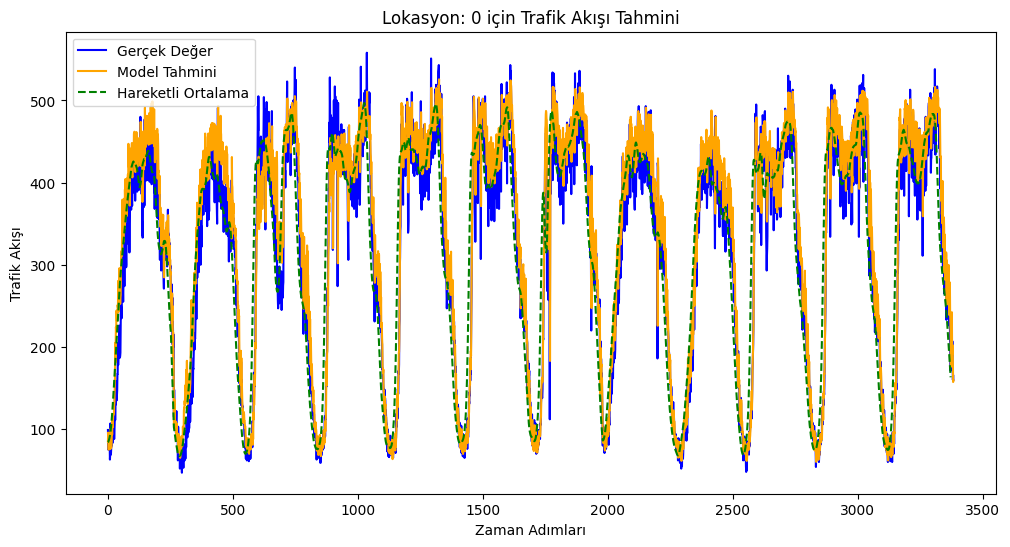

Gerçek değerler (ilk 10): [99. 87. 75. 88. 82. 99. 76. 82. 63. 69.]
Tahmin edilen değerler (ilk 10): [85.16 95.79 82.96 74.9  85.77 79.59 94.6  79.17 82.05 75.82]


In [169]:
plot_prediction(Y_test[:, 0], Y_pred_inv[:, 0], test_moving_average, location=locations[0])

print("Gerçek değerler (ilk 10):", np.round(Y_test[:10, 0], 2))
print("Tahmin edilen değerler (ilk 10):", np.round(Y_pred_inv[:10, 0], 2))